## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import geopandas as gpd
import contextily as ctx

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [4]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD
from pesuelogit.etl import data_curation, add_period_id

# Functions from internal modules
from nesuelogit.models import compute_generated_trips, compute_generation_factors,  \
    create_tvodlulpe_model_fresno, create_tvgodlulpe_model_fresno
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import  plot_predictive_performance, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, \
    plot_convergence_estimates, plot_parameters
from nesuelogit.metrics import mse, mdape, r2_score, z2score
from nesuelogit.utils import read_paths

In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

In [7]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231212003020


## Read nodes and link-specific data

In [8]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

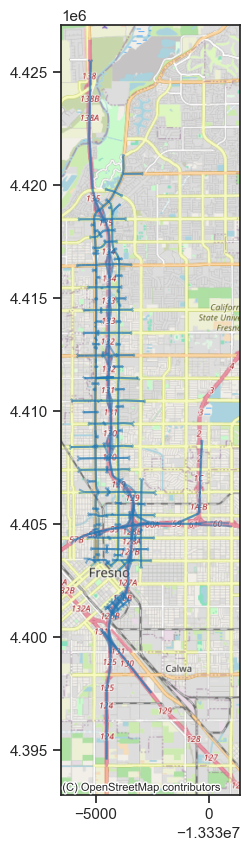

In [9]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## Build Fresno network

In [10]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

## Read OD matrix

In [11]:
read_OD(network=network, sparse=True)

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], 6, axis=0)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [12]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')
# read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')

18289 paths were read and incidence matrices were built


## Read spatiotemporal data

In [13]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday (1) to Thursday (3)
df = df[df['date'].dt.dayofweek.between(1, 3)]
# # Select data from one day only in 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

In [14]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [15]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period,period_id
0,"(0, 1621, 0)",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10,4
1,"(1239, 1630, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
2,"(228, 192, 0)",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10,4
3,"(1243, 1631, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
4,"(1244, 1632, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4


In [16]:
# Units in miles per hour
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

,speed_ref_avg,speed_hist_avg,speed_max
count,1.013460e+06,1.009583e+06,1.013460e+06
mean,1.924470e+01,1.767589e+01,2.051278e+01
std,1.982261e+01,1.909664e+01,2.140424e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.112700e+01,1.755400e+01,2.112700e+01
75%,2.796200e+01,2.547600e+01,3.106900e+01
max,6.772900e+01,7.891400e+01,8.388500e+01


In [17]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [18]:
df.loc[df['speed_ref_avg']<=0,'speed_ref_avg'] = float('nan')

df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [19]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [20]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg,tt_sd_adj
count,599370.000000,1.009583e+06,1.013460e+06,887813.000000,1.013460e+06
mean,32.540388,1.767589e+01,2.038423e-01,0.219493,3.022799e-04
std,15.223625,1.909664e+01,2.610045e-01,0.262030,4.638521e-04
min,8.078000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,24.233000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,26.719000,1.755400e+01,1.497376e-01,0.167050,1.856268e-04
75%,32.933000,2.547600e+01,2.792397e-01,0.312986,4.248116e-04
max,67.729000,7.891400e+01,4.220601e+00,3.827439,1.243267e-02


## Node data

In [21]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

In [22]:
features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [23]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [24]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [25]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.204903,0.221931,0.200169,0.018137
std,770.228931,0.262226,0.266852,0.228208,0.027831
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.150455,0.168820,0.152000,0.011138
75%,2162.450000,0.282111,0.318261,0.280000,0.025489
max,4807.000000,4.220601,3.827439,2.302000,0.745960


In [26]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.202618,0.216770,0.198494,0.018137
std,743.713869,0.259583,0.256512,0.226003,0.027831
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.149437,0.165341,0.150000,0.011138
75%,1978.000000,0.274658,0.306717,0.273000,0.025489
max,4766.000000,4.220601,3.274444,2.113000,0.745960


In [27]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

In [28]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

,counts,tt_avg
counts,1.000000,0.055122
tt_avg,0.055122,1.000000


## EDA

In [29]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [30]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Link attributes

In [31]:
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [32]:
_DTYPE = tf.float32

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z,
                             links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

In [33]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6
#growth_factor = 1

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(
    q = q_historic, ods= network.ods, n_nodes = len(network.nodes))

## Configuration

In [34]:
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = {'tvodlulpe': True, 'tvgodlulpe': False}
_LR = {'learning': 1e-1, 'equilibrium': 1e-2}
_RELATIVE_GAP = 1e-4
_BATCH_SIZE = 1
_EPOCHS = {'learning': 30, 'equilibrium': 30}
# _BATCH_SIZE = None
# _EPOCHS = {'learning': 3, 'equilibrium': 3}
_LOSS_METRIC  = z2score
_EVALUATION_METRIC = mdape
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }
_XTICKS_SPACING = 5

## Models

In [35]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

### Benchmark (TVODLULPE)

In [36]:
# To report runtime
t0 = time.time()

models['tvodlulpe'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods, historic_q = q_historic,
                                                    features_Z = _FEATURES_Z, dtype = _DTYPE)

In [37]:
train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS,
    node_data=nodes_df,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvodlulpe'],
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['tvodlulpe'].save_weights(f"output/models/{ts}_fresno_tvodlulpe.h5")


Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       27  mdape
1  traveltime       41  mdape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 90, threshold relative gap: 0.0001
training set -> timepoints: 90, obs [t x]: [2073.  140.], coverage [t x]: [0.86 0.06]
validation set -> timepoints: 78, obs [t x]: [2139.  140.], coverage [t x]: [0.89 0.06]

Learning stage: 3 epochs

0/6: train mse=6.1e+05, train mse traveltime=2, train mdape traveltime=18.9 train mse flow=1.7e+06, train mdape flow=48.4, val mse=7.3e+05, val mse traveltime=1.9, val mdape traveltime=18.6 val mse flow=1.9e+06, val mdape flow=4

In [38]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
# metrics_df = pd.concat([metrics_df,
#                         models['tvodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
#                                                                  X=XT_val, Y=YT_val).assign(dataset='validation'),
#                         compute_benchmark_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
#                                                   Y=YT_val).assign(
#                             dataset='benchmark')
#                         ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])


metric                mdape      mse    r2
component   dataset                       
equilibrium training    2.8 5.53e+04 0.943
flow        training   47.1 1.61e+06 -1.64
traveltime  training   16.4    0.273 -3.15


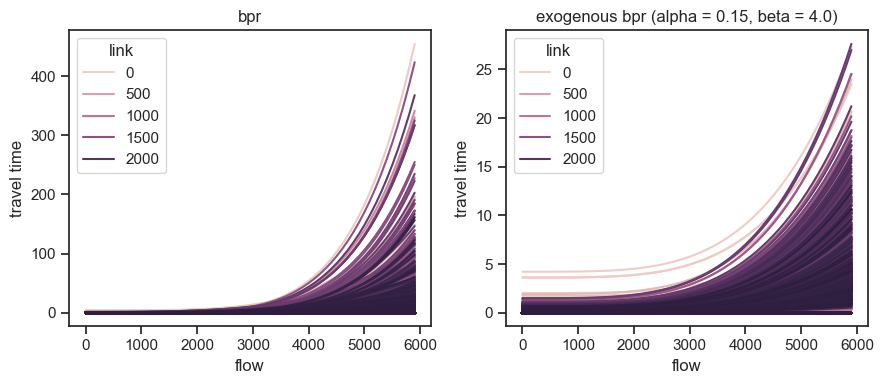

In [39]:
flow_range = range(0,6000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      #alpha=models['tvodlulpe'].performance_function.alpha,
                                      #beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                                      )

# for ax in axs.reshape(-1):
#     ax.set_xlim(xmin=-10)
#     ax.set_ylim(ymin=-1)
#     ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

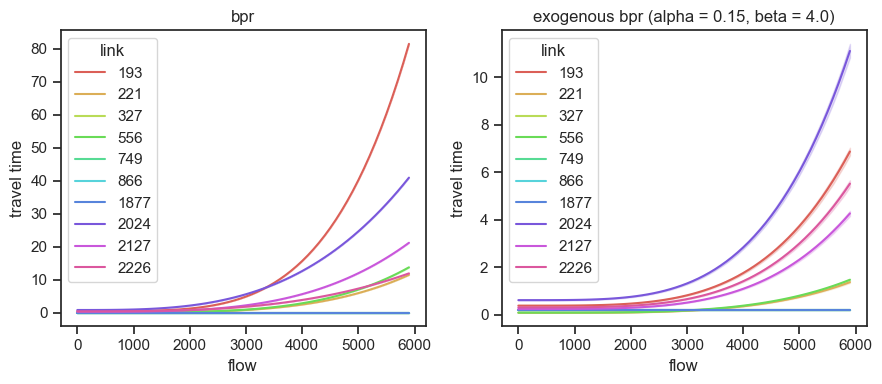

In [40]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

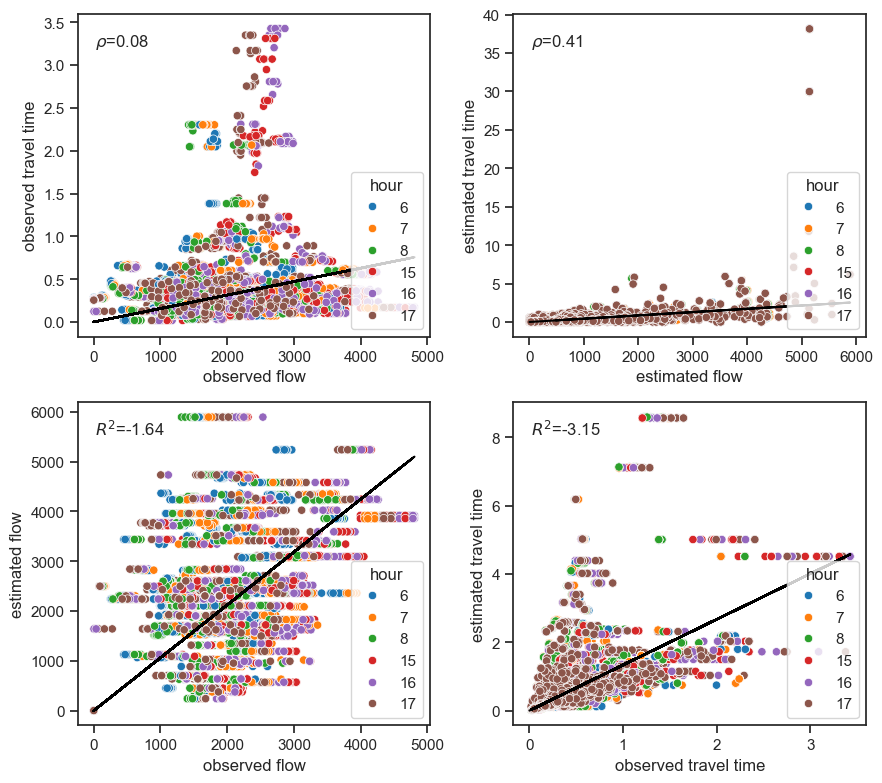

In [41]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

(<Figure size 550x500 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mdape (%)'>)

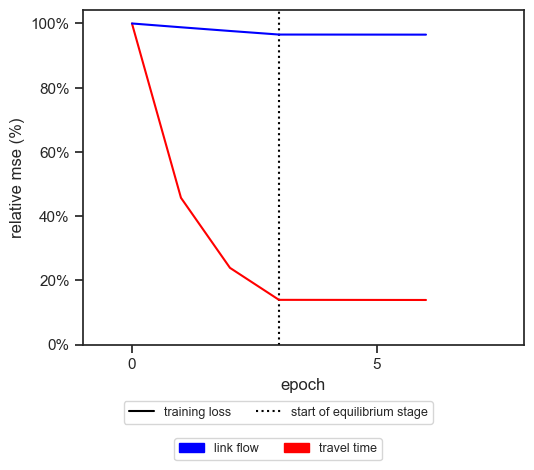

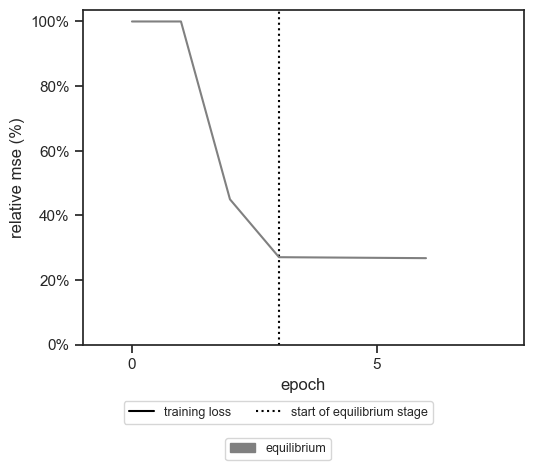

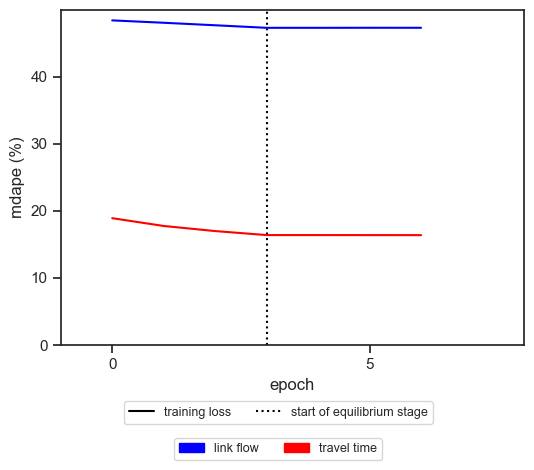

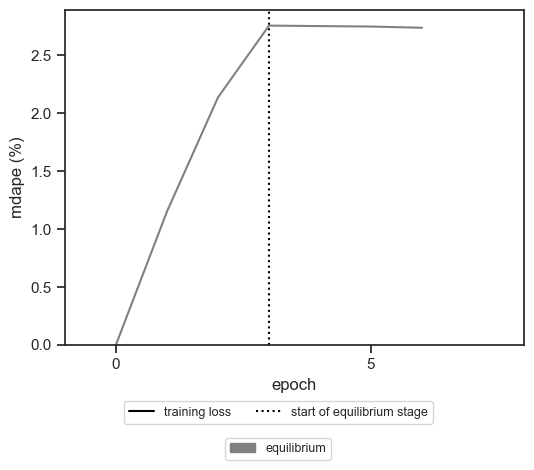

In [42]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

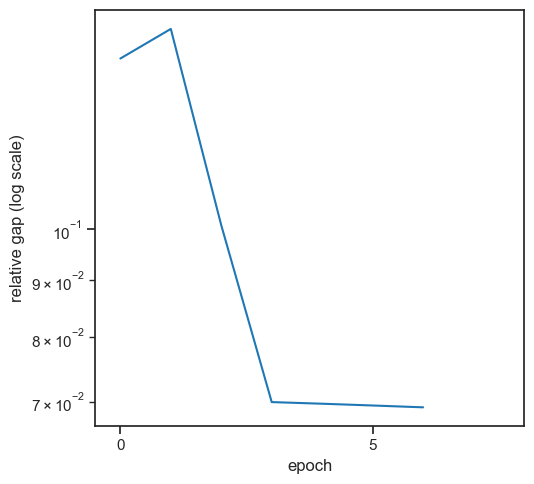

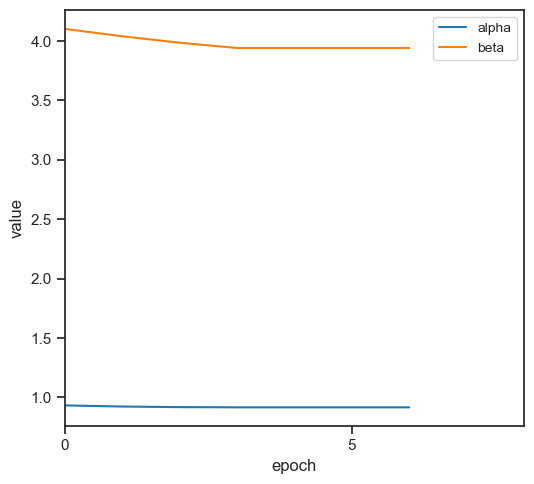

In [43]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png')

plt.show()

plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=_XTICKS_SPACING)
plt.show()

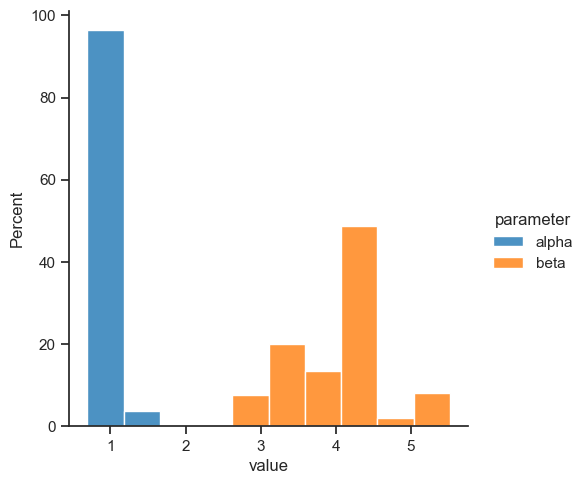

             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
6-7   -2.937245 -3.452672         0.0  -4.578398        0.0      -3.874887   
7-8   -3.079851 -3.331123         0.0  -4.507479        0.0      -4.110987   
8-9   -2.944777 -3.287425         0.0  -4.578188        0.0      -3.868398   
15-16 -3.084629 -3.357736         0.0  -4.506579        0.0      -4.104107   
16-17 -2.958986 -3.281964         0.0  -4.566421        0.0      -3.877153   
17-18 -2.970410 -3.272584         0.0  -4.561915        0.0      -3.877632   

       hour  
6-7       6  
7-8       7  
8-9       8  
15-16    15  
16-17    16  
17-18    17  


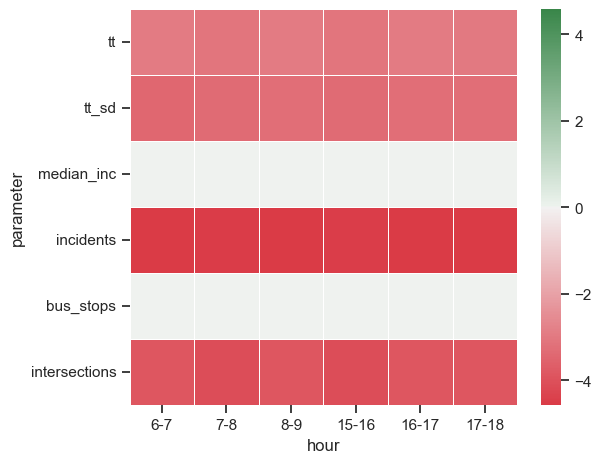

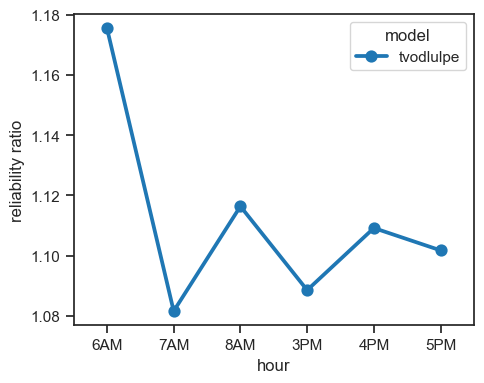

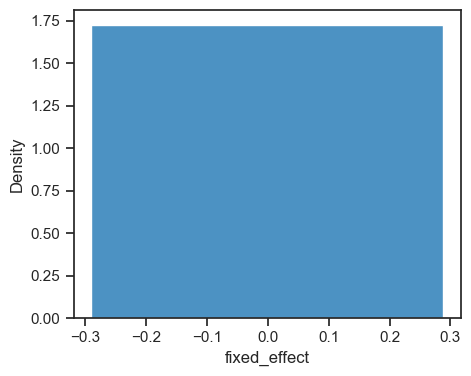

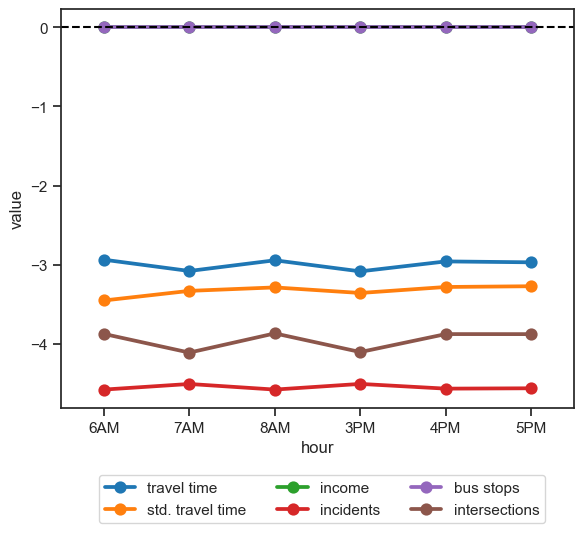

In [44]:
#sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                              'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

try:
    sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)
    plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png')
    plt.show()
except:
    print('Distribution plot could not be shown')

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'],period_keys, model_key = 'tvodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvodlulpe'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png')

plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:801: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od          6AM          7AM          8AM          3PM  \
 1618 175     1840.4001  1820.131714  1816.556274  1820.135986  1816.757324   
      694     1182.4533  1166.326538  1163.537964  1166.329956  1163.695435   
 42   1617    1139.6952  1134.205444  1137.141846  1133.260132  1135.063354   
 693  1617    1077.8859  1071.085327  1073.361206  1071.737061  1073.796875   
 272  1614     598.5315   597.629700   597.649963   597.670593   597.636047   
 701  1629     577.9746   590.842163   590.885742   590.839478   590.843018   
 226  1651     472.3362   460.074371   460.049347   460.073975   460.067932   
 220  1688     446.1534   434.581421   434.564636   434.588043   434.591064   
 104  1693     430.1766   418.440430   418.418793   418.429016   418.418243   
 871  1679     428.9796   417.198669   417.155426   417.180511   417.153473   
 1615 88       426.7179   426.815247   426.791840   426.519928   426.561920   
 807  1650     418.2822   406.869385   406.824890   

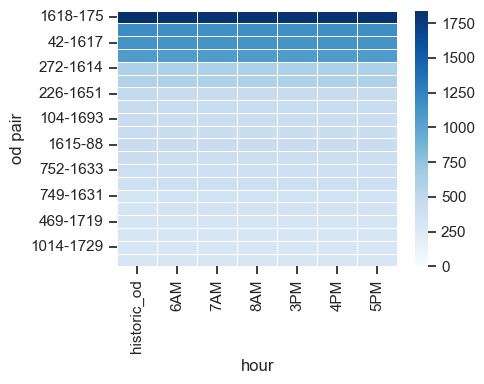

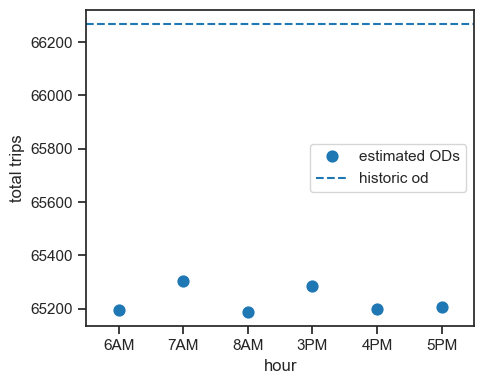

In [45]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [46]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -2.9959831, 'tt_sd': -3.3305843, 'median_inc': 0.0, 'incidents': -4.54983, 'bus_stops': 0.0, 'intersections': -3.9521942}
alpha =  0.92, beta  =  3.94
Avg abs diff of observed and estimated OD:  0.45
Avg observed OD:  9.51


### TVGODLULPE

In [47]:
print('\ntvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

models['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                      historic_g = generated_trips, historic_q = q_historic)


tvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions


In [48]:
train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= _OPTIMIZERS,
    batch_size=_BATCH_SIZE,
    # batch_size=None,
    loss_weights= _LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvgodlulpe'],
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['tvgodlulpe'].save_weights(f"output/models/{ts}_fresno_tvgodlulpe.h5")


Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       27  mdape
1  traveltime       41  mdape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters los

In [49]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
# metrics_df = pd.concat([metrics_df,
#                         models['tvgodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
#                                                                  X=XT_val, Y=YT_val).assign(dataset='validation'),
#                         compute_benchmark_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
#                                                   Y=YT_val).assign(
#                             dataset='benchmark')
#                         ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])
print(f'runtime: {time.time()-t0:0.1f} [s]')

metric                mdape      mse    r2
component   dataset                       
equilibrium training   5.26 1.09e+05 0.925
flow        training   60.4 2.96e+06 -3.85
traveltime  training   57.7     34.9  -529
runtime: 43.2 [s]


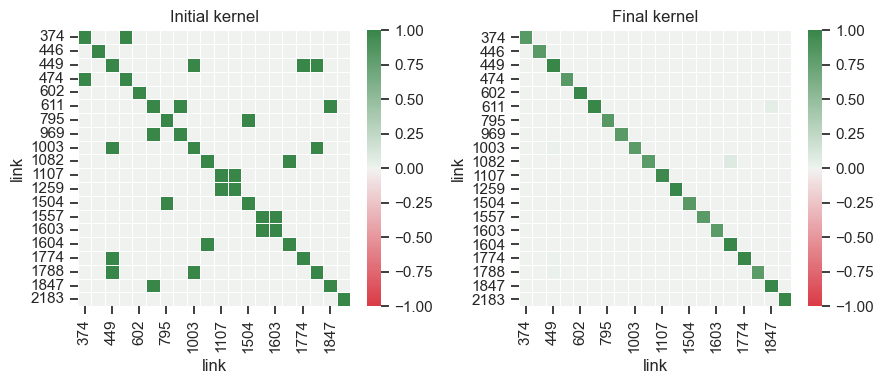

Final weights interaction:
 [[1.0229 0.     0.     ... 0.     0.     0.    ]
 [0.     1.01   0.     ... 0.     0.     0.    ]
 [0.     0.0505 1.0991 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.8589 0.     0.    ]
 [0.     0.     0.     ... 0.     0.858  0.    ]
 [0.     0.     0.     ... 0.     0.     1.    ]]

Initial weights interaction:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [50]:
selected_links = np.random.choice(range(network.get_n_links()), 20, replace=False)

#weights_interaction = models['tvgodlulpe'].performance_function.weights[1].numpy()
weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    # flow_interaction_matrix=np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    # masking_matrix = np.where(initial_weights_interaction>0, 1, -1)*np.where(initial_weights_interaction==0, 0, 1),
    links_ids = selected_links + 1,
    # vmin = -0.05, vmax = 0.05
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

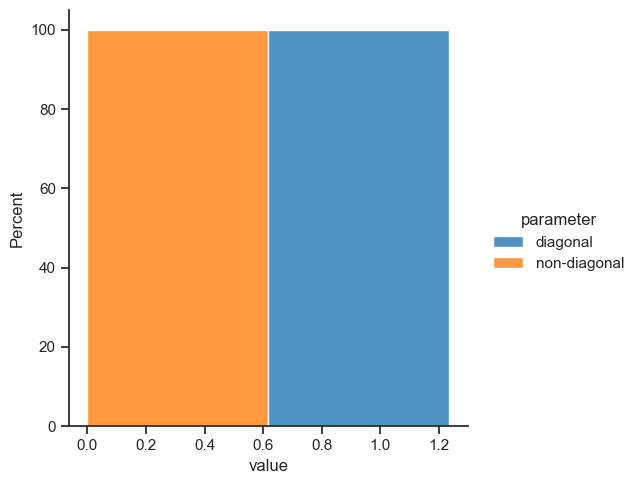

                 value  value_abs
parameter                        
diagonal      0.919647   0.919647
non-diagonal  0.016182   0.016182
              value
parameter          
diagonal       2413
non-diagonal  12314


In [51]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

try:
    sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
                facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"
    plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvgodlulpe.png')
    plt.show()
except:
    print('Distribution plot could not be shown')

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [52]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.8193 0.8221 0.8247 0.8273]


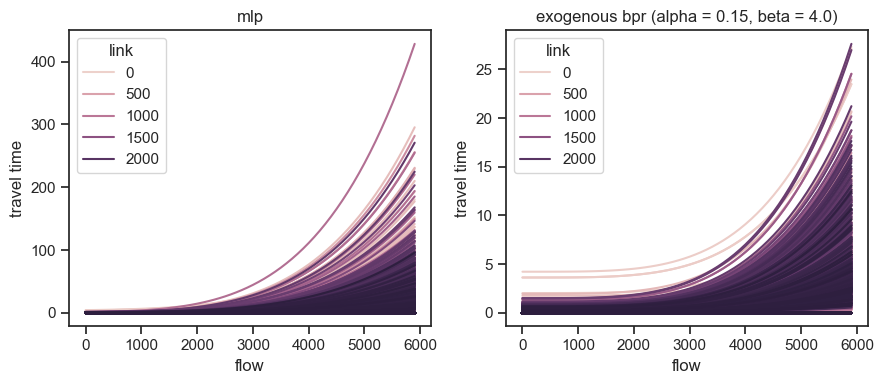

In [53]:
flow_range = range(0,6000,100)
sharey = False

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = False,
                           alpha= 0.15, #models['tvodlulpe'].performance_function.alpha,
                           beta= 4, #models['tvodlulpe'].performance_function.beta,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

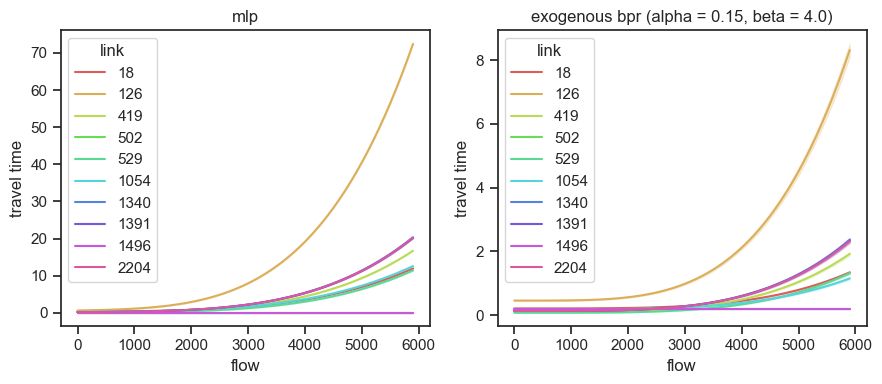

In [54]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = True,
                           selected_links = selected_links,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )
plt.show()

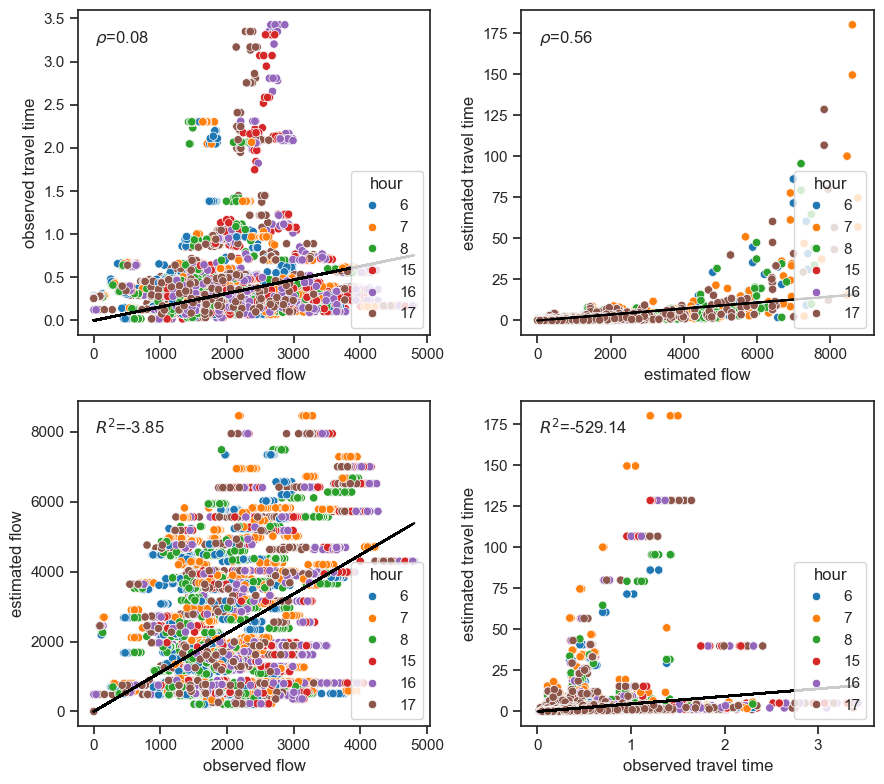

In [55]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

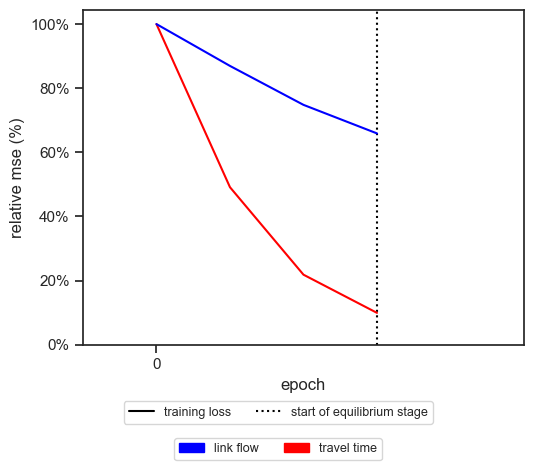

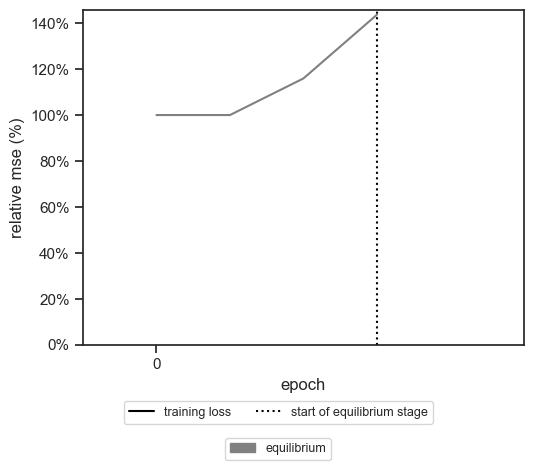

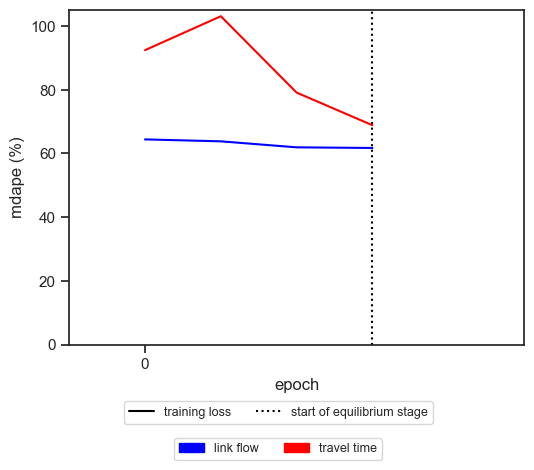

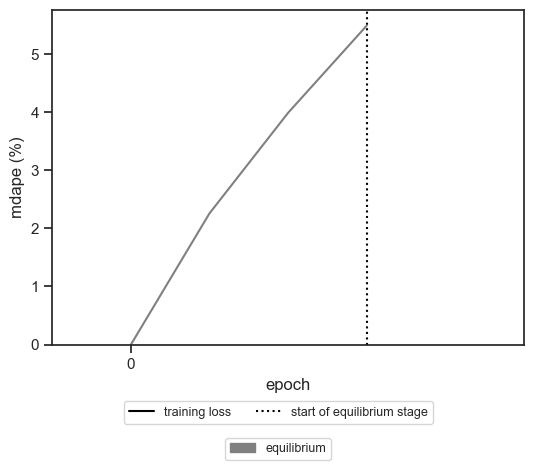

In [56]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')


plt.show()

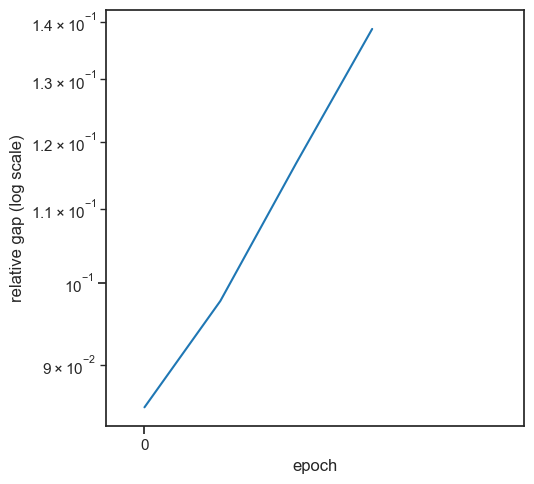

In [57]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2)
# ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvgodlulpe.png')

plt.show()

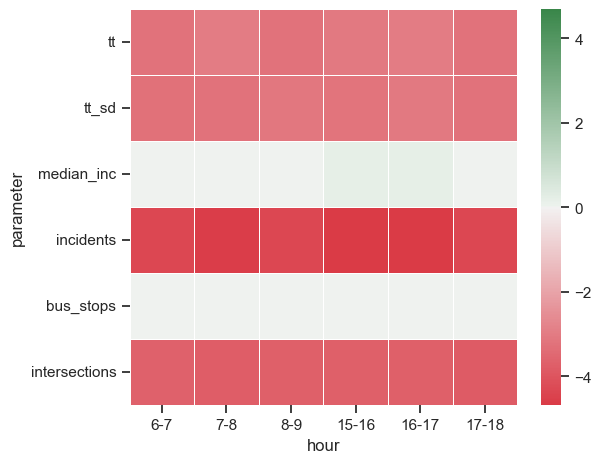

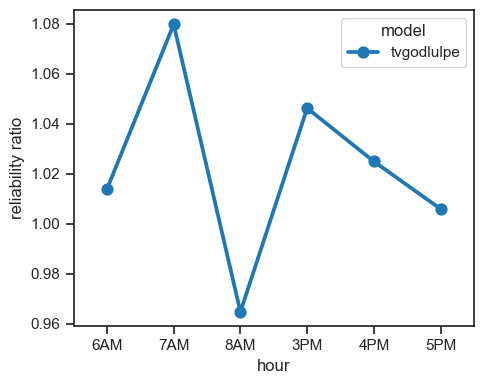

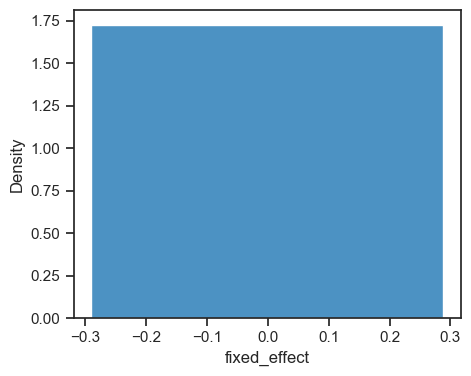

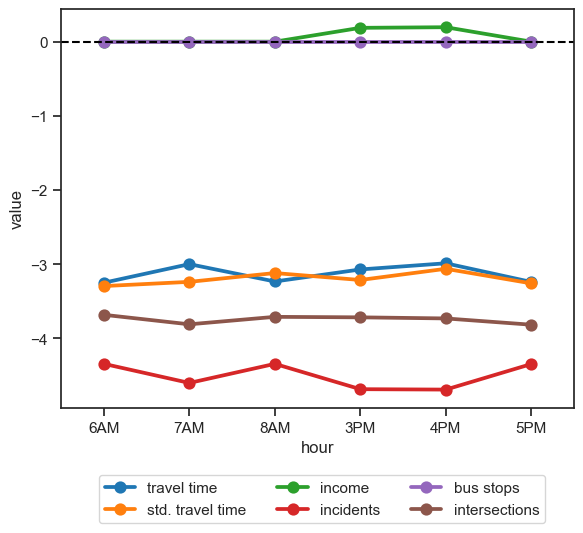

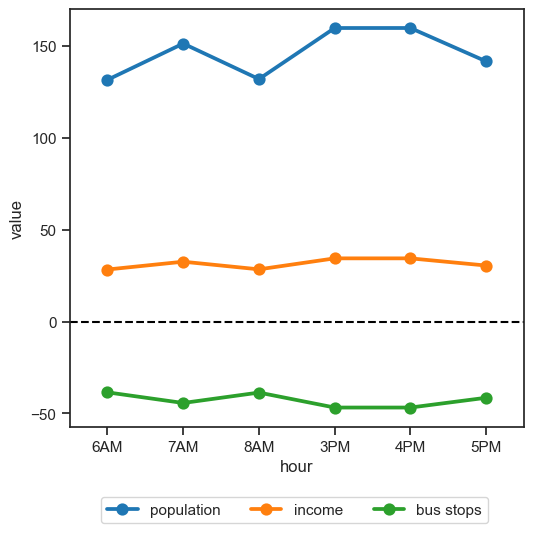

Theta: [[-3.251  -3.     -3.2343 -3.072  -2.9887 -3.2405]
 [-3.2959 -3.2391 -3.1204 -3.214  -3.0631 -3.2596]
 [ 0.      0.      0.      0.1866  0.1949  0.    ]
 [-4.3448 -4.6025 -4.345  -4.6865 -4.6921 -4.3476]
 [ 0.      0.      0.      0.      0.      0.    ]
 [-3.6835 -3.8117 -3.711  -3.7177 -3.7325 -3.817 ]]
Kappa: [[131.4958 151.2198 131.8887 159.6779 159.6841 141.5333]
 [ 28.293   32.5369  28.3776  34.3568  34.3581  30.4527]
 [-38.5438 -44.3253 -38.659  -46.8045 -46.8064 -41.486 ]]


In [58]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['tvgodlulpe'], period_keys, model_key = 'tvgodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['tvgodlulpe'].kappa[period, i].numpy()]}) for period in range(models['tvgodlulpe'].kappa.shape[0]) for i, feature in enumerate(models['tvgodlulpe'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvgodlulpe'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvgodlulpe.png')

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-tvgodlulpe.png')

plt.show()

print('Theta:', models['tvgodlulpe'].theta.numpy().T)
print('Kappa:', models['tvgodlulpe'].kappa.numpy().T)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:801: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od         6AM         7AM         8AM         3PM  \
 1618 175     1840.4001    4.955041    5.485744    4.908461    5.981143   
      694     1182.4533    4.955057    5.489254    4.908254    5.980962   
 42   1617    1139.6952    5.419915    6.019030    5.375190    6.550285   
 693  1617    1077.8859    7.097316    7.893426    7.037441    8.569271   
 272  1614     598.5315    6.992876    7.833307    6.927829    8.445834   
 701  1629     577.9746   13.618545   16.097010   13.532490   16.456600   
 226  1651     472.3362    3.745879    4.528077    3.728486    4.530502   
 220  1688     446.1534    4.189534    4.904236    4.167262    5.065361   
 104  1693     430.1766    2.975769    3.487610    2.957902    3.596608   
 871  1679     428.9796    3.597481    4.192055    3.587859    4.355888   
 1615 88       426.7179  624.278687  718.044312  626.120117  758.065674   
 807  1650     418.2822    6.494231    7.805416    6.458772    7.850957   
 752  1633     392.5845  

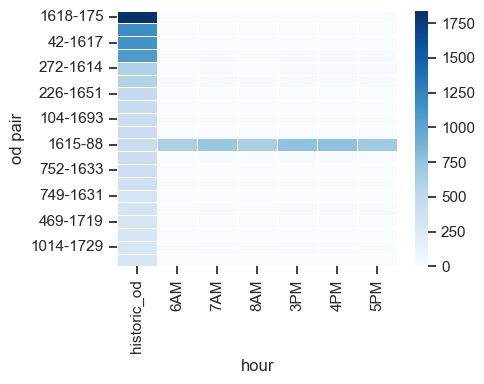

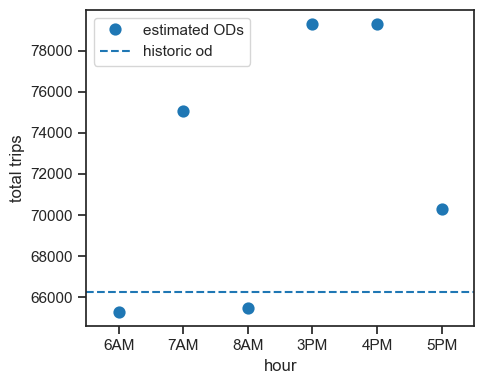

In [59]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [60]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

if models['tvgodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvgodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvgodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.1310625, 'tt_sd': -3.1986856, 'median_inc': 0.06358433, 'incidents': -4.503058, 'bus_stops': 0.0, 'intersections': -3.7455864}
kappa= {'population': 145.91658, 'income': 31.395859, 'bus_stops': -42.770832}
Avg abs diff of observed and estimated OD:  12.85
Avg observed OD:  9.51


## Write estimation results

In [61]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{ts}_train_results_{network.key}.csv"
val_filename = f"{ts}_validation_results_{network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 231212003020_train_results_fresno.csv was written
File 231212003020_validation_results_fresno.csv was written


## Summary of parameter estimates

### All models

In [62]:
models

{'tvodlulpe': <nesuelogit.models.NESUELOGIT at 0x33ae774f0>,
 'tvgodlulpe': <nesuelogit.models.NESUELOGIT at 0x2981d0940>}

In [63]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [64]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

model              tvodlulpe  tvgodlulpe
parameter                               
tt                   -2.9960     -3.1311
tt_sd                -3.3306     -3.1987
median_inc            0.0000      0.0636
incidents            -4.5498     -4.5031
bus_stops             0.0000      0.0000
intersections        -3.9522     -3.7456
rr                    1.1117      1.0216
fixed_effect_mean    -0.0036      0.0021
fixed_effect_std      0.1085      0.1034
od_mean               9.3587     10.3945
od_std               41.1630     15.6318
alpha_mean            0.9165         NaN
alpha_std             0.1264         NaN
beta_mean             3.9410         NaN
beta_std              0.5810         NaN


### TVGODLULPE

In [65]:
# Stats by period
model = models['tvgodlulpe']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

theta:         0       1       2       3       4       5
0 -3.2510 -3.0000 -3.2343 -3.0720 -2.9887 -3.2405
1 -3.2959 -3.2391 -3.1204 -3.2140 -3.0631 -3.2596
2  0.0000  0.0000  0.0000  0.1866  0.1949  0.0000
3 -4.3448 -4.6025 -4.3450 -4.6865 -4.6921 -4.3476
4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
5 -3.6835 -3.8117 -3.7110 -3.7177 -3.7325 -3.8170


In [66]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

kappa:          0        1        2        3        4        5
0 131.4958 151.2198 131.8887 159.6779 159.6841 141.5333
1  28.2930  32.5369  28.3776  34.3568  34.3581  30.4527
2 -38.5438 -44.3253 -38.6590 -46.8045 -46.8064 -41.4860


In [67]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

OD matrix                   0          1          2          3          4          5
od_mean      9.3663    10.7731     9.3947    11.3750    11.3755    10.0824
od_std      14.0369    16.1058    14.0553    17.0436    17.0426    15.0655
od_total 65283.4141 75088.5000 65481.3789 79283.5703 79287.1562 70274.2344


## Summary of models goodness of fit

In [68]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [69]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

        model  epoch  loss_traveltime           loss_od  loss_theta  \
3   tvodlulpe      3         -86.0500 180016033449.1424         NaN   
3  tvgodlulpe      3         -90.0858            0.9972         NaN   

   loss_flow  loss_equilibrium  loss_bpr  loss_ntrips      loss_prop_od  \
3    -3.4475          -72.9359       NaN          NaN 172582666627.8970   
3   -34.1013           43.7220       NaN          NaN            0.9971   

   loss_regularizer_kernel  loss_regularizer_utility_ods  loss_regularizer_od  \
3                      NaN                           NaN                  NaN   
3                      NaN                           NaN                  NaN   

   loss_total  relative_gap       model  
3     -9.2481        0.0700   tvodlulpe  
3    -32.6972        0.1388  tvgodlulpe  


## Plot of convergence toward true rr across models

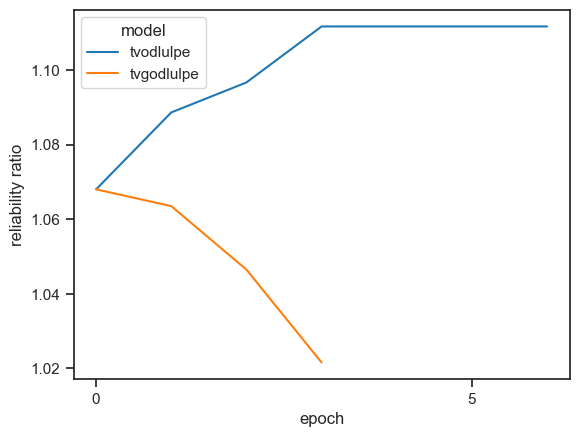

In [70]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

# ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 2, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of reliability ratio by hour for all models

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:865: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=rr_by_hour_models, x=period_feature + '_id', y="rr", ax=ax,


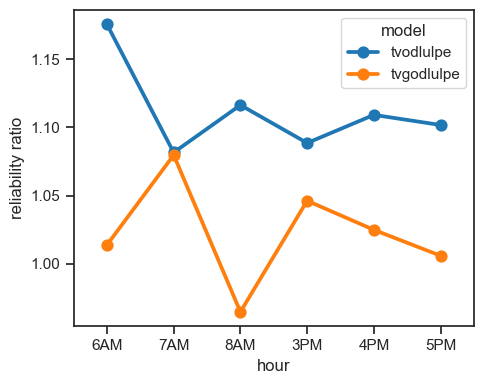

In [71]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png')

plt.show()

In [72]:
print(reliability_ratios)

         rr  hour hour_id       model
0  1.175480     6     6AM   tvodlulpe
0  1.013831     6     6AM  tvgodlulpe
1  1.081586     7     7AM   tvodlulpe
1  1.079703     7     7AM  tvgodlulpe
2  1.116358     8     8AM   tvodlulpe
2  0.964785     8     8AM  tvgodlulpe
3  1.088538    15     3PM   tvodlulpe
3  1.046220    15     3PM  tvgodlulpe
4  1.109151    16     4PM   tvodlulpe
4  1.024898    16     4PM  tvgodlulpe
5  1.101728    17     5PM   tvodlulpe
5  1.005911    17     5PM  tvgodlulpe


In [73]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'tvgodlulpe'][['hour','rr']].T)

          0      1      2       3       4       5
hour 6.0000 7.0000 8.0000 15.0000 16.0000 17.0000
rr   1.0138 1.0797 0.9648  1.0462  1.0249  1.0059


In [74]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

                rr
model             
tvgodlulpe  1.0226
tvodlulpe   1.1121


## Plot of total trips by hour for all models

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:942: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data= total_trips_by_hour_models, x=period_feature, y='total_trips', ax=ax,


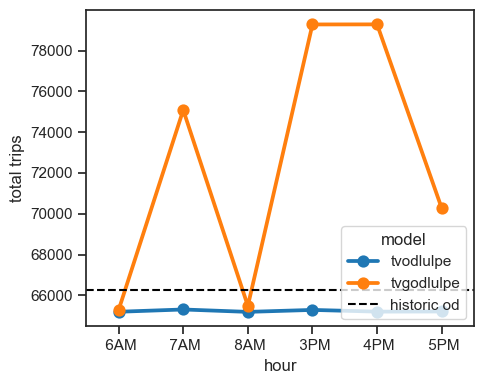

In [75]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      historic_od = network.q.flatten(), join = True)

plt.savefig('output/figures/results/fresno-total-trips-periods.png')

plt.show()

In [76]:
print(total_trips)

   hour   total_trips       model  order
0   6AM  65194.402344   tvodlulpe      6
0   6AM  65283.527344  tvgodlulpe      6
1   7AM  65305.742188   tvodlulpe      7
1   7AM  75088.320312  tvgodlulpe      7
2   8AM  65188.539062   tvodlulpe      8
2   8AM  65481.308594  tvgodlulpe      8
3   3PM  65284.585938   tvodlulpe     15
3   3PM  79283.507812  tvgodlulpe     15
4   4PM  65200.718750   tvodlulpe     16
4   4PM  79287.046875  tvgodlulpe     16
5   5PM  65207.210938   tvodlulpe     17
5   5PM  70274.453125  tvgodlulpe     17


In [77]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

,total_trips
model,
tvgodlulpe,72449.703125
tvodlulpe,65230.199219


In [78]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

,total_trips
model,
tvgodlulpe,434698.1875
tvodlulpe,391381.1875




## Global runtime

In [79]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 268.0 [s]
